In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
print(tf.__version__)
print(keras.__version__)

2.2.0
2.3.0-tf


# 一 一般模型的构造、训练、测试流程

In [2]:
# 模型构造
inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)

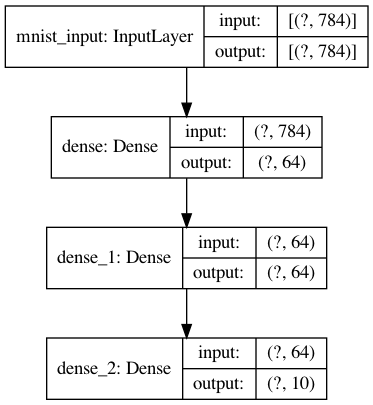

In [3]:
keras.utils.plot_model(model, 'net001.png', show_shapes=True)

In [4]:
# 模型编译
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [5]:
# 载入数据
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') /255
x_test = x_test.reshape(10000, 784).astype('float32') /255

x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [6]:
# 训练模型
history = model.fit(x_train, y_train, batch_size=64, epochs=3,
         validation_data=(x_val, y_val))
print('history:')
print(history.history)

Epoch 1/3
782/782 [==============================] - 1s 1ms/step - loss: 0.3374 - sparse_categorical_accuracy: 0.9028 - val_loss: 0.1869 - val_sparse_categorical_accuracy: 0.9452
Epoch 2/3
782/782 [==============================] - 1s 1ms/step - loss: 0.1638 - sparse_categorical_accuracy: 0.9514 - val_loss: 0.1358 - val_sparse_categorical_accuracy: 0.9625
Epoch 3/3
782/782 [==============================] - 1s 1ms/step - loss: 0.1210 - sparse_categorical_accuracy: 0.9637 - val_loss: 0.1196 - val_sparse_categorical_accuracy: 0.9670
history:
{'loss': [0.3373929262161255, 0.16376349329948425, 0.12096083164215088], 'sparse_categorical_accuracy': [0.9027799963951111, 0.9513999819755554, 0.963699996471405], 'val_loss': [0.1869364082813263, 0.13576552271842957, 0.11957114189863205], 'val_sparse_categorical_accuracy': [0.9452000260353088, 0.9624999761581421, 0.9670000076293945]}


In [7]:
# 验证
result = model.evaluate(x_test, y_test, batch_size=128)
print('evaluate:')
print(result)

79/79 [==============================] - 0s 992us/step - loss: 0.1210 - sparse_categorical_accuracy: 0.9640
evaluate:
[0.1210034191608429, 0.9639999866485596]


In [8]:
# 预测
pred = model.predict(x_test[:2])
print('predict:')
print(pred)

predict:
[[7.9272844e-08 2.4325981e-08 1.7843488e-05 1.6991945e-04 2.2156739e-09
  1.4676035e-06 3.0944847e-12 9.9977714e-01 1.4217727e-07 3.3358952e-05]
 [9.3406788e-07 2.0751820e-04 9.9966800e-01 6.5498389e-05 1.3010475e-12
  5.2543826e-05 2.3772755e-06 4.4947761e-08 3.0699866e-06 3.1939429e-12]]


# 二 自定义损失和指标

## 1 自定义指标
### 方法一 继承Metric类
自定义指标只需继承Metric类， 并重写一下函数

_init_(self)，初始化。

update_state(self，y_true，y_pred，sample_weight = None)，它使用目标y_true和模型预测y_pred来更新状态变量。

result(self)，它使用状态变量来计算最终结果。

reset_states(self)，重新初始化度量的状态。

In [9]:
# 这是一个简单的示例，显示如何实现CatgoricalTruePositives指标，该指标计算正确分类为属于给定类的样本数量

class CatgoricalTruePostives(keras.metrics.Metric):
    def __init__(self, name='binary_true_postives', **kwargs):
        super(CatgoricalTruePostives, self).__init__(name=name, **kwargs)
        self.true_postives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred)
        y_true = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))

        y_true = tf.cast(y_true, tf.float32)

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, tf.float32)
            y_true = tf.multiply(sample_weight, y_true)

        return self.true_postives.assign_add(tf.reduce_sum(y_true))

    def result(self):
        return tf.identity(self.true_postives)

    def reset_states(self):
        self.true_postives.assign(0.)

In [10]:
model.compile(optimizer=keras.optimizers.RMSprop(1e-3),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[CatgoricalTruePostives()])

history = model.fit(x_train, y_train, batch_size=64, epochs=3)
print(history.history)

Epoch 1/3
782/782 [==============================] - 1s 1ms/step - loss: 0.0968 - binary_true_postives: 8129.0000
Epoch 2/3
782/782 [==============================] - 1s 1ms/step - loss: 0.0805 - binary_true_postives: 7928.0000
Epoch 3/3
782/782 [==============================] - 1s 1ms/step - loss: 0.0689 - binary_true_postives: 8266.0000
{'loss': [0.09683869779109955, 0.08049371838569641, 0.06889117509126663], 'binary_true_postives': [8129.0, 7928.0, 8266.0]}


### 方法二 定义网络层添加需统计的metric

In [11]:
# 也可以以定义网络层的方式添加要统计的metric
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        self.add_metric(keras.backend.std(inputs),
                       name='std_of_activation',
                       aggregation='mean')
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = MetricLoggingLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)

# 构造网络等价于
# inputs = keras.Input(shape=(784,), name='mnist_input')
# h1 = layers.Dense(64, activation='relu')(inputs)
# h2 = layers.Dense(64, activation='relu')(h1)
# outputs = layers.Dense(10, activation='softmax')(h2)
# model = keras.Model(inputs, outputs)

# model.add_metric(keras.backend.std(inputs),
#                        name='std_of_activation',
#                        aggregation='mean')

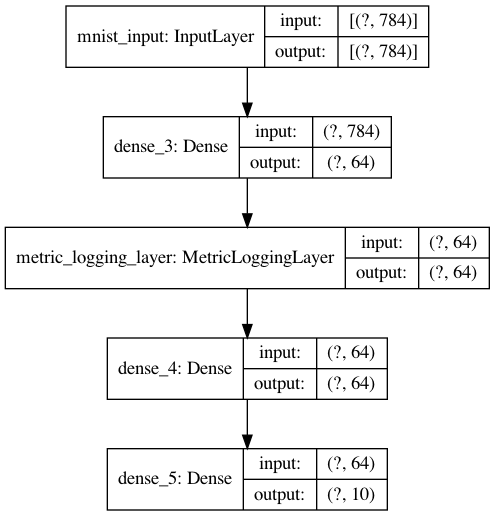

In [12]:
keras.utils.plot_model(model, 'net002.png', show_shapes=True)

In [13]:
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])
history = model.fit(x_train, y_train, batch_size=32, epochs=1)
print(history.history)

1563/1563 [==============================] - 2s 1ms/step - loss: 0.2984 - sparse_categorical_accuracy: 0.9118 - std_of_activation: 0.9533A: 0s - loss: 0.3430 - sparse_categorical_accuracy: 0.8990 - std_of_activa
{'loss': [0.2983883321285248], 'sparse_categorical_accuracy': [0.9118000268936157], 'std_of_activation': [0.9533095359802246]}


## 2 自定义损失

In [14]:
# 以定义网络层的方式添加网络loss
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h1 = ActivityRegularizationLayer()(h1)
h1 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h1)
model = keras.Model(inputs, outputs)

# 构造网络等价于
# inputs = keras.Input(shape=(784,), name='mnist_input')
# h1 = layers.Dense(64, activation='relu')(inputs)
# h2 = layers.Dense(64, activation='relu')(h1)
# outputs = layers.Dense(10, activation='softmax')(h2)
# model = keras.Model(inputs, outputs)
# model.add_loss(tf.reduce_sum(h1)*0.1)

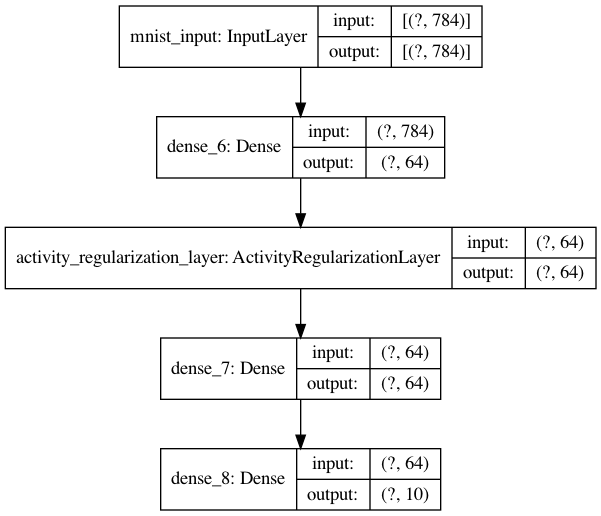

In [15]:
keras.utils.plot_model(model, 'net003.png', show_shapes=True)

In [16]:
model.compile(optimizer=keras.optimizers.RMSprop(),
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

history = model.fit(x_train, y_train, batch_size=32, epochs=1)
print(history.history)

1563/1563 [==============================] - 2s 1ms/step - loss: 2.3640 - sparse_categorical_accuracy: 0.1129
{'loss': [2.3640332221984863], 'sparse_categorical_accuracy': [0.1129399985074997]}


# 三 使用tf.data构造数据

In [17]:
def get_compiled_model():
    inputs = keras.Input(shape=(784,), name='mnist_input')
    h1 = layers.Dense(64, activation='relu')(inputs)
    h2 = layers.Dense(64, activation='relu')(h1)
    outputs = layers.Dense(10, activation='softmax')(h2)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.RMSprop(),
                 loss=keras.losses.SparseCategoricalCrossentropy(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()])
    return model

model = get_compiled_model()
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

# model.fit(train_dataset, epochs=3)
# steps_per_epoch 每个epoch只训练几步
# validation_steps 每次验证，验证几步
history = model.fit(train_dataset, epochs=3, steps_per_epoch=100,
             validation_data=val_dataset, validation_steps=3)
print(history.history)

Epoch 1/3
100/100 [==============================] - 0s 2ms/step - loss: 0.7992 - sparse_categorical_accuracy: 0.7944 - val_loss: 0.3786 - val_sparse_categorical_accuracy: 0.8906
Epoch 2/3
100/100 [==============================] - 0s 1ms/step - loss: 0.3818 - sparse_categorical_accuracy: 0.8919 - val_loss: 0.3215 - val_sparse_categorical_accuracy: 0.9010
Epoch 3/3
100/100 [==============================] - 0s 1ms/step - loss: 0.3232 - sparse_categorical_accuracy: 0.9069 - val_loss: 0.2437 - val_sparse_categorical_accuracy: 0.9167
{'loss': [0.7991724610328674, 0.3817708492279053, 0.3231588304042816], 'sparse_categorical_accuracy': [0.7943750023841858, 0.8918750286102295, 0.9068750143051147], 'val_loss': [0.3785804510116577, 0.32150909304618835, 0.24366529285907745], 'val_sparse_categorical_accuracy': [0.890625, 0.9010416865348816, 0.9166666865348816]}


# 四 样本权重和类权重
“样本权重”数组是一个数字数组，用于指定批处理中每个样本在计算总损失时应具有多少权重。 它通常用于不平衡的分类问题（这个想法是为了给予很少见的类更多的权重）。 当使用的权重是1和0时，该数组可以用作损失函数的掩码（完全丢弃某些样本对总损失的贡献）。

“类权重”dict是同一概念的更具体的实例：它将类索引映射到应该用于属于该类的样本的样本权重。 例如，如果类“0”比数据中的类“1”少两倍，则可以使用class_weight = {0：1.，1：0.5}。

In [18]:
# 增加第5类的权重
import numpy as np

# 类权重，这里表示分类为5的样本为其他分类的一半
# model = get_compiled_model()
# class_weight = {i:1.0 for i in range(10)}
# class_weight[5] = 2.0
# print(class_weight)
# history = model.fit(x_train, y_train,
#                     class_weight=class_weight,
#                     batch_size=64,
#                     epochs=4)

# 样本权重，表示效果同上，不同表达
# model = get_compiled_model()
# sample_weight = np.ones(shape=(len(y_train),))
# sample_weight[y_train == 5] = 2.0
# history = model.fit(x_train, y_train,
#                     sample_weight=sample_weight,
#                     batch_size=64,
#                     epochs=4)

# tf.data数据
model = get_compiled_model()

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train,
                                                    sample_weight))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# 验证集使用权重
# val_weight = np.ones(shape=(len(y_val),))
# val_weight[y_val == 5] = 2.0

# val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val,
#                                                  val_weight))

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

history = model.fit(train_dataset, epochs=3, 
                    validation_data=val_dataset, validation_steps=3)
print(history.history)

Epoch 1/3
782/782 [==============================] - 1s 2ms/step - loss: 0.3708 - sparse_categorical_accuracy: 0.9036 - val_loss: 0.1611 - val_sparse_categorical_accuracy: 0.9479
Epoch 2/3
782/782 [==============================] - 1s 1ms/step - loss: 0.1717 - sparse_categorical_accuracy: 0.9521 - val_loss: 0.0788 - val_sparse_categorical_accuracy: 0.9792
Epoch 3/3
782/782 [==============================] - 1s 1ms/step - loss: 0.1266 - sparse_categorical_accuracy: 0.9649 - val_loss: 0.1140 - val_sparse_categorical_accuracy: 0.9688
{'loss': [0.37076976895332336, 0.17169472575187683, 0.12661902606487274], 'sparse_categorical_accuracy': [0.9036200046539307, 0.9521200060844421, 0.9648799896240234], 'val_loss': [0.16114236414432526, 0.07878977060317993, 0.11395449191331863], 'val_sparse_categorical_accuracy': [0.9479166865348816, 0.9791666865348816, 0.96875]}


In [19]:
# tf.data数据
model = get_compiled_model()

sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train,
                                                    sample_weight))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

val_weight = np.ones(shape=(len(y_val),))
val_weight[y_val == 5] = 2.0

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val,
                                                 val_weight))

val_dataset = val_dataset.batch(64)

history = model.fit(train_dataset, epochs=3, 
                    validation_data=val_dataset, validation_steps=3)
print(history.history)

Epoch 1/3
782/782 [==============================] - 1s 2ms/step - loss: 0.3666 - sparse_categorical_accuracy: 0.9036 - val_loss: 0.2044 - val_sparse_categorical_accuracy: 0.9479
Epoch 2/3
782/782 [==============================] - 1s 2ms/step - loss: 0.1791 - sparse_categorical_accuracy: 0.9505 - val_loss: 0.1325 - val_sparse_categorical_accuracy: 0.9583
Epoch 3/3
782/782 [==============================] - 1s 2ms/step - loss: 0.1330 - sparse_categorical_accuracy: 0.9629 - val_loss: 0.0920 - val_sparse_categorical_accuracy: 0.9844
{'loss': [0.3665533661842346, 0.17910617589950562, 0.132967010140419], 'sparse_categorical_accuracy': [0.9036399722099304, 0.9504799842834473, 0.96288001537323], 'val_loss': [0.2044307440519333, 0.1324818879365921, 0.09196767956018448], 'val_sparse_categorical_accuracy': [0.9479166865348816, 0.9583333134651184, 0.984375]}


结论：验证集使用权重后，理论上loss会上升，但同时准确率也会较之前提高

# 五 多输入多输出模型

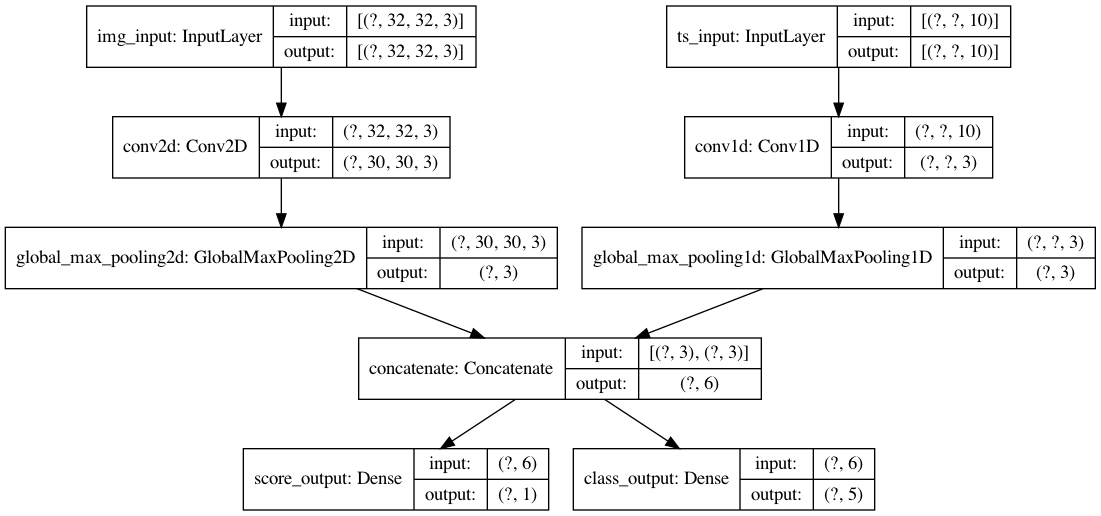

In [20]:
image_input = keras.Input(shape=(32, 32, 3), name='img_input')
timeseries_input = keras.Input(shape=(None, 10), name='ts_input')

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name='score_output')(x)
class_output = layers.Dense(5, activation='softmax', name='class_output')(x)

model = keras.Model(inputs=[image_input, timeseries_input],
                    outputs=[score_output, class_output])

keras.utils.plot_model(model, 'multi_input_output_model.png'
                       , show_shapes=True)

In [21]:
# 可以为模型指定不同的loss和metrics
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(),
          keras.losses.CategoricalCrossentropy()])


# 还可以指定loss的权重
# model.compile(
#     optimizer=keras.optimizers.RMSprop(1e-3),
#     loss={'score_output': keras.losses.MeanSquaredError(),
#           'class_output': keras.losses.CategoricalCrossentropy()},
#     metrics={'score_output': [keras.metrics.MeanAbsolutePercentageError(),
#                               keras.metrics.MeanAbsoluteError()],
#              'class_output': [keras.metrics.CategoricalAccuracy()]},
#     loss_weight={'score_output': 2., 'class_output': 1.})

# 可以把不需要传播的loss置0
# model.compile(
#     optimizer=keras.optimizers.RMSprop(1e-3),
#     loss=[None, keras.losses.CategoricalCrossentropy()])

# Or dict loss version
# model.compile(
#     optimizer=keras.optimizers.RMSprop(1e-3),
#     loss={'class_output': keras.losses.CategoricalCrossentropy()})

# 六 使用回调
Keras中的回调是在训练期间（在epoch开始时，batch结束时，epoch结束时等）在不同点调用的对象，可用于实现以下行为：

* 在培训期间的不同时间点进行验证（超出内置的每个时期验证）
* 定期检查模型或超过某个精度阈值
* 在训练似乎平稳时改变模型的学习率
* 在训练似乎平稳时对顶层进行微调
* 在培训结束或超出某个性能阈值时发送电子邮件或即时消息通知等等。

**可使用的内置回调有**

* ModelCheckpoint：定期保存模型。
* EarlyStopping：当训练不再改进验证指标时停止培训。
* TensorBoard：定期编写可在TensorBoard中显示的模型日志（更多细节见“可视化”）。
* CSVLogger：将丢失和指标数据流式传输到CSV文件。
* 等等

## 1 回调使用

In [22]:
# 早停
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # 是否有提升关注的指标
        monitor='val_loss',
        # 不再提升的阈值
        min_delta=1e-2,
        # 2个epoch没有提升就停止
        patience=2,
        verbose=1)
]

model.fit(x_train, y_train,
          epochs=20,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Epoch 1/20
625/625 [==============================] - 2s 2ms/step - loss: 0.3670 - sparse_categorical_accuracy: 0.8978 - val_loss: 0.2286 - val_sparse_categorical_accuracy: 0.9320
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1722 - sparse_categorical_accuracy: 0.9482 - val_loss: 0.1749 - val_sparse_categorical_accuracy: 0.9468
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 0.1270 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.1508 - val_sparse_categorical_accuracy: 0.9568
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 0.0997 - sparse_categorical_accuracy: 0.9694 - val_loss: 0.1413 - val_sparse_categorical_accuracy: 0.9588
Epoch 5/20
625/625 [==============================] - 1s 2ms/step - loss: 0.0817 - sparse_categorical_accuracy: 0.9761 - val_loss: 0.1311 - val_sparse_categorical_accuracy: 0.9621
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.0693 - sparse_categorica

In [23]:
# checkpoint模型回调
model = get_compiled_model()

check_callback = keras.callbacks.ModelCheckpoint(
    filepath='mymodel_{epoch}.h5',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

model.fit(x_train, y_train,
         epochs=3,
         batch_size=64,
         callbacks=[check_callback],
         validation_split=0.2)

Epoch 1/3
604/625 [===========================>..] - ETA: 0s - loss: 0.3718 - sparse_categorical_accuracy: 0.8945
Epoch 00001: val_loss improved from inf to 0.23073, saving model to mymodel_1.h5
625/625 [==============================] - 1s 2ms/step - loss: 0.3667 - sparse_categorical_accuracy: 0.8957 - val_loss: 0.2307 - val_sparse_categorical_accuracy: 0.9300
Epoch 2/3
586/625 [===========================>..] - ETA: 0s - loss: 0.1707 - sparse_categorical_accuracy: 0.9486
Epoch 00002: val_loss improved from 0.23073 to 0.18938, saving model to mymodel_2.h5
625/625 [==============================] - 1s 2ms/step - loss: 0.1698 - sparse_categorical_accuracy: 0.9491 - val_loss: 0.1894 - val_sparse_categorical_accuracy: 0.9428
Epoch 3/3
601/625 [===========================>..] - ETA: 0s - loss: 0.1219 - sparse_categorical_accuracy: 0.9628
Epoch 00003: val_loss improved from 0.18938 to 0.15862, saving model to mymodel_3.h5
625/625 [==============================] - 1s 2ms/step - loss: 0.1220

In [24]:
# 动态调整学习率
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

inputs = keras.Input(shape=(784,), name='mnist_input')
h1 = layers.Dense(64, activation='relu')(inputs)
h2 = layers.Dense(64, activation='relu')(h1)
outputs = layers.Dense(10, activation='softmax')(h2)
model = keras.Model(inputs, outputs)
model.compile(optimizer=optimizer,
             loss=keras.losses.SparseCategoricalCrossentropy(),
             metrics=[keras.metrics.SparseCategoricalAccuracy()])

# 使用tensorboard
tensorboard_cbk = keras.callbacks.TensorBoard(log_dir='./logs')

model.fit(x_train, y_train,
         epochs=5,
         batch_size=64,
         callbacks=[tensorboard_cbk],
         validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 1s 2ms/step - loss: 2.7099 - sparse_categorical_accuracy: 0.3422 - val_loss: 1.7445 - val_sparse_categorical_accuracy: 0.3856
Epoch 2/5
625/625 [==============================] - 1s 2ms/step - loss: 1.6877 - sparse_categorical_accuracy: 0.3144 - val_loss: 1.6926 - val_sparse_categorical_accuracy: 0.2946
Epoch 3/5
625/625 [==============================] - 1s 2ms/step - loss: 1.6924 - sparse_categorical_accuracy: 0.2828 - val_loss: 1.8450 - val_sparse_categorical_accuracy: 0.1862
Epoch 4/5
625/625 [==============================] - 1s 2ms/step - loss: 1.8441 - sparse_categorical_accuracy: 0.1968 - val_loss: 1.8945 - val_sparse_categorical_accuracy: 0.2042
Epoch 5/5
625/625 [==============================] - 1s 2ms/step - loss: 1.8483 - sparse_categorical_accuracy: 0.1980 - val_loss: 1.8482 - val_sparse_categorical_accuracy: 0.2048


## 2 自定义回调函数

In [25]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.losses = []
    def on_epoch_end(self, batch, logs):
        self.losses.append(logs.get('loss'))
        print('\nloss:',self.losses[-1])

model = get_compiled_model()

callbacks = [
    LossHistory()
]
model.fit(x_train, y_train,
          epochs=3,
          batch_size=64,
          callbacks=callbacks,
          validation_split=0.2)

Epoch 1/3
591/625 [===========================>..] - ETA: 0s - loss: 0.3811 - sparse_categorical_accuracy: 0.8928
loss: 0.37221866846084595
625/625 [==============================] - 1s 2ms/step - loss: 0.3722 - sparse_categorical_accuracy: 0.8952 - val_loss: 0.2246 - val_sparse_categorical_accuracy: 0.9319
Epoch 2/3
615/625 [============================>.] - ETA: 0s - loss: 0.1713 - sparse_categorical_accuracy: 0.9482
loss: 0.17089442908763885
625/625 [==============================] - 1s 2ms/step - loss: 0.1709 - sparse_categorical_accuracy: 0.9483 - val_loss: 0.1755 - val_sparse_categorical_accuracy: 0.9463
Epoch 3/3
605/625 [============================>.] - ETA: 0s - loss: 0.1267 - sparse_categorical_accuracy: 0.9615
loss: 0.12589748203754425
625/625 [==============================] - 1s 1ms/step - loss: 0.1259 - sparse_categorical_accuracy: 0.9617 - val_loss: 0.1666 - val_sparse_categorical_accuracy: 0.9506


# 七 自定义构造训练和验证循环

## 训练并验证

In [38]:
# 训练并验证
# 获取模型
inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

# sgd优化器
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

# 分类损失函数
loss_fn = keras.losses.SparseCategoricalCrossentropy()

# 设定统计参数
train_acc_metric = keras.metrics.SparseCategoricalAccuracy() 
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()

# 准备训练数据
batch_size = 64
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# 准备验证数据
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)


# 迭代训练
for epoch in range(3):
    print('Start of epoch %d' % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # 更新统计传输
        train_acc_metric(y_batch_train, logits)

        # 输出
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))

    # 输出统计参数的值
    train_acc = train_acc_metric.result()
    print('Training acc over epoch: %s' % (float(train_acc),))
        
    # 重置统计参数
    train_acc_metric.reset_states()

    # 用模型进行验证
    for x_batch_val, y_batch_val in val_dataset:
        val_logits = model(x_batch_val)
        # 根据验证的统计参数
        val_acc_metric(y_batch_val, val_logits)
    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print('Validation acc: %s' % (float(val_acc),))

Start of epoch 0
Training loss (for one batch) at step 0: 2.3064017295837402
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.280001401901245
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.174821376800537
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.102450370788574
Seen so far: 38464 samples
Training acc over epoch: 0.31196001172065735
Validation acc: 0.4887000024318695
Start of epoch 1
Training loss (for one batch) at step 0: 2.0293033123016357
Seen so far: 64 samples
Training loss (for one batch) at step 200: 1.894104242324829
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 1.8210548162460327
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 1.7716436386108398
Seen so far: 38464 samples
Training acc over epoch: 0.5603399872779846
Validation acc: 0.6518999934196472
Start of epoch 2
Training loss (for one batch) at step 0: 1.6335967779159546
Seen so far: 64 samples
Training

In [39]:
##　添加自己构造的loss, 每次只能看到最新一次训练增加的loss
class ActivityRegularizationLayer(layers.Layer):

    def call(self, inputs):
        self.add_loss(1e-2 * tf.reduce_sum(inputs))
        return inputs

inputs = keras.Input(shape=(784,), name='digits')
x = layers.Dense(64, activation='relu', name='dense_1')(inputs)
# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)
x = layers.Dense(64, activation='relu', name='dense_2')(x)
outputs = layers.Dense(10, activation='softmax', name='predictions')(x)

model = keras.Model(inputs=inputs, outputs=outputs)
logits = model(x_train[:64])
print(model.losses)
logits = model(x_train[:64])
logits = model(x_train[64: 128])
logits = model(x_train[128: 192])
print(model.losses)
# 将loss添加进求导中
optimizer = keras.optimizers.SGD(learning_rate=1e-3)

for epoch in range(3):
    print('Start of epoch %d' % (epoch,))

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train)
            loss_value = loss_fn(y_batch_train, logits)

            # 添加额外的loss
            loss_value += sum(model.losses)

        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # 每200个batch输出一次学习.
        if step % 200 == 0:
            print('Training loss (for one batch) at step %s: %s' % (step, float(loss_value)))
            print('Seen so far: %s samples' % ((step + 1) * 64))

[<tf.Tensor: shape=(), dtype=float32, numpy=6.5006733>]
[<tf.Tensor: shape=(), dtype=float32, numpy=6.547977>]
Start of epoch 0
Training loss (for one batch) at step 0: 8.892967224121094
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.541232109069824
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.4225268363952637
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.336982011795044
Seen so far: 38464 samples
Start of epoch 1
Training loss (for one batch) at step 0: 2.3284807205200195
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3222813606262207
Seen so far: 12864 samples
Training loss (for one batch) at step 400: 2.338780641555786
Seen so far: 25664 samples
Training loss (for one batch) at step 600: 2.306298017501831
Seen so far: 38464 samples
Start of epoch 2
Training loss (for one batch) at step 0: 2.305915117263794
Seen so far: 64 samples
Training loss (for one batch) at step 200: 2.3209366798400